## <center> Студенческий проект, неофициальная реализация по статье "Nasrullah, Z. and Zhao, Y., Musical Artist Classification with Convolutional Recurrent Neural Networks. International Joint Conference on Neural Networks (IJCNN), 2019."</center>
### <center>Статья: https://arxiv.org/pdf/1901.04555.pdf</center>

**<center>Московский государственный университет имени М.В.Ломоносова</center>**

**<center>Факультет вычислительной математики и кибернетики</center>**

**<center>Кафедра математических методов прогнозирования</center>**

<center><b>Команда "2 Миньона и Гераклы" в составе: <i>Алексей Думбай, Виктор Януш, Сергей Серов, Анна Липкина.</i>
</b></center>

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import time
import pickle
from collections import Counter, defaultdict
import itertools

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, TensorDataset
import librosa
import librosa.display
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from tqdm import tqdm
import seaborn as sns
sns.set()

from music_classification.feature_extractor.data_holder import DataHolder
from music_classification.feature_extractor.mel_extractor import MelExtractor
from music_classification.utils import train_model
from music_classification.models.crnn import CRNN

%matplotlib inline

### Часть 1. Загрузка данных

**Датасет artist20 взят отсюда: https://labrosa.ee.columbia.edu/projects/artistid/**

In [2]:
DATA_PATH = "./data/artist20/"
SAMPLING_RATE = 16000
data_holder = DataHolder(**{"sr" : SAMPLING_RATE}) # FIX ME AFTER HOTFIX!!!

In [3]:
#data_holder.process_folder(DATA_PATH)

In [4]:
DATASET_PREPROCESSED_PATH = "./data/artist20_preprocessed.pkl"
#data_holder.save_dataset(DATASET_PREPROCESSED_PATH)

**Загрузка датасета:**

In [5]:
data_holder.load_dataset(DATASET_PREPROCESSED_PATH)

### Часть 2. Разбиение данных на тренировочную, тестовую и валидационную выборки

In [6]:
SLICE_LENGTH = 100
# each window --- SLICE_LENGTH / 32 second

#### Разбиение по песням

In [7]:
song_split_data = data_holder.get_song_split(slice_length=SLICE_LENGTH, overlap=30)

#### Разбиение по альбомам

In [8]:
album_split_data = data_holder.get_album_split(slice_length=SLICE_LENGTH, overlap=30)

### Часть 3. Создание моделей и их обучение

**Параметры моделей**

In [9]:
NUM_CLASSES = len(data_holder.artists_codes)
NUM_CLASSES

20

In [10]:
FREQ_DIM = song_split_data["train"][0].shape[1]
FREQ_DIM

128

**Проверка правильности построения датасетов**

In [11]:
for data_type in ("train", "validation", "test"):
    assert(song_split_data[data_type][0].shape[1] == FREQ_DIM)
    assert(album_split_data[data_type][0].shape[1] == FREQ_DIM)

### Обучение моделей

#### Song-split

In [ ]:
NUM_MODELS = 1
models_song = []
OUT_PATH_SONG = "./models/model_song_dataset_artist20_overlap30_epoch_40"

for i in range(NUM_MODELS):
    model_song = CRNN(
            freq_dim=FREQ_DIM,
            channel_dim=1, # MONO
            num_classes=NUM_CLASSES)

    result_song = train_model(
                    model=model_song,
                    data=song_split_data,
                    n_epochs=40,
                    save_dir=OUT_PATH_SONG)
    models_song.append(model_song)
    print(f"TRAINED {i + 1} MODEL OF {NUM_MODELS}")

In [13]:
best_model_song = CRNN(
           freq_dim=FREQ_DIM,
           channel_dim=1, # MONO
           num_classes=NUM_CLASSES)
best_model_song.load_state_dict(torch.load(OUT_PATH_SONG + "/best_model_010.model")["model_state_dict"])
best_model_song.eval()
models_song2 = [best_model_song]

#### Album-split

In [ ]:
NUM_MODELS = 1
models_album = []
OUT_PATH_ALBUM = "./models/model_album_dataset_artist20_overlap30_epoch_40"

for i in range(NUM_MODELS):
    model_album = CRNN(
                freq_dim=FREQ_DIM,
                channel_dim=1, # MONO
                num_classes=NUM_CLASSES)
    result_albums = train_model(
                        model=model_album,
                        data=album_split_data,
                        n_epochs=40,
                        save_dir=OUT_PATH_ALBUM)
    models_album.append(model_album)
    print(f"TRAINED {i + 1} MODEL OF {NUM_MODELS}")

In [26]:
best_model_album = CRNN(
       freq_dim=FREQ_DIM,
       channel_dim=1, # MONO
       num_classes=NUM_CLASSES)
#print(torch.load("./res/best_model_024.model"))
best_model_album.load_state_dict(torch.load(OUT_PATH_ALBUM + "/best_model_004.model")["model_state_dict"])
best_model_album.eval()
models_album2 = [best_model_album]

### Часть 4. Подсчет метрик на тестовых датасетах, эксперименты

In [14]:
def make_dataset_and_loader(data, shuffle=True, batch_size=32):
    """
    Almost a copy of function in utils.train_model
    
    returns:
    dataset -- TensorDataset
    loader -- torch.utils.data.DataLoader
    """
    X, y = [torch.from_numpy(t) for t in data[:2]]
    X = X.unsqueeze(dim=1).type(torch.float32)
    dataset = TensorDataset(X, y)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataset, loader

In [15]:
def get_f1_score_and_accuracy(report_stat):
    """
    Get F1-weighted score and accuracy score from report statistic of sklearn function classification_report
    
    returns:
    f1_score -- F1-weighted score for multiclass classification task
    accuracy -- accuracy score for classification task
    """
    f1_score = float(report_stat.strip().split("\n")[-1].split()[-2])
    accuracy = float(report_stat.strip().split("\n")[-3].split()[-2])
    return f1_score, accuracy

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          out_path="./images/cm0.png",
                          cmap=plt.cm.get_cmap('Blues')):
    """
    !!!
    taken from original code
    https://github.com/ZainNasrullah/music-artist-classification-crnn/blob/master/src/utility.py
    !!!
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.figure(figsize=(17, 17))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=16)
    plt.yticks(tick_marks, classes, fontsize=16)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(float(format(cm[i, j], fmt)), ".2g"),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=14)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)
    plt.savefig(out_path)
    plt.show()

In [17]:
def plot_tsne(model, test_data, data_holder, experiment_name="experiment_0"):
    """
    !!!
    Part of code is taken from here:
    https://github.com/ZainNasrullah/music-artist-classification-crnn/blob/master/representation.py
    !!!
    
    plot scatter plot of test_data via t-SNE of inner model's representation. Use input of last FC layer
    
    params:
    model -- trained model
    test_data -- input data
    data_holder -- for get encoding-decoding for songs and artists
    out_path -- path for save image
    """
    model.eval()
    cudnn.benchmark = False
    dev = torch.device("cuda")
    model.to(dev)
    
    true_song_names = test_data[2]
    true_song_author_names = [data_holder.songs_artists[x] for x in true_song_names]
    
    dataset, loader = make_dataset_and_loader(test_data[:2], shuffle=False, batch_size=32)
    
    X_repr = []
    with torch.no_grad():
        for batch in tqdm(loader):
            X_repr.append(model.get_representation(batch[0].to(dev)).cpu())
            torch.cuda.empty_cache()
    X_repr = np.vstack(X_repr)
    
    tsne_model = TSNE()
    X_2d = tsne_model.fit_transform(X_repr)
    
    sns.set(font_scale=1.5)
    sns.set_palette("Paired", n_colors=NUM_CLASSES)
    plt.figure(figsize=(20, 20))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1],
                    hue=true_song_author_names, palette=sns.color_palette(n_colors=NUM_CLASSES), s=50)
    plt.savefig(f"./images/tsne_{experiment_name}.png")
    plt.show()
    sns.set()

In [18]:
def visualize_spectrogram(path, duration=None,
                          offset=0, sr=16000, n_mels=128, n_fft=2048,
                          hop_length=512):
    """This function creates a visualization of a spectrogram
    given the path to an audio file."""

    # Make a mel-scaled power (energy-squared) spectrogram
    y, sr = librosa.load(path, sr=sr, duration=duration, offset=offset)
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=n_mels, n_fft=n_fft,
                                       hop_length=hop_length)

    # Convert to log scale (dB)
    log_S = librosa.logamplitude(S, ref_power=1.0)

    # Render output spectrogram in the console
    plt.figure(figsize=(12, 5))
    librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
    plt.title('mel power spectrogram')
    plt.colorbar(format='%+02.0f dB')
    plt.tight_layout()


In [19]:
def plot_mel(test_data, data_holder, sr, experiment_name="experiment_0"):
    """
    !!! Part of code is taken from here
    https://github.com/ZainNasrullah/music-artist-classification-crnn/blob/master/src/utility.py
    !!!
    
    Visualize mel spectrograms for random sampled songs for each author
    """
    X = test_data[0]
    true_song_names = test_data[2]
    true_song_author_names = [data_holder.songs_artists[x] for x in true_song_names]
    songs_from_artist = defaultdict(list)
    for song_name in np.unique(true_song_names):
        songs_from_artist[data_holder.songs_artists[song_name]].append(song_name)
        
    random_songs = [(k, np.random.choice(v)) for (k, v) in songs_from_artist.items()]
    
    plt.figure(figsize=(20, 20))
    for i, (author, song) in enumerate(random_songs):
    #for song_path in ["./data/artist20/aerosmith/Aerosmith/01-Make_It.mp3"]:
        #y, _ = librosa.load(song_path, sr=sr, offset=60, duration=3)
        #S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128,
                                           #n_fft=2048, hop_length=512)
        #mels = librosa.amplitude_to_db(S, ref=1.0)
        idxs = (true_song_names == song)
        mels = X[idxs]
        cnt_parts = mels.shape[0]
        mels = mels[cnt_parts // 2]
        plt.subplot(5, 4, i + 1)
        #plt.subplot(1, 1, 1)
        #librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
        librosa.display.specshow(mels, sr=sr, x_axis='time', y_axis='mel')
        plt.title(author, fontsize=18)
        #plt.title("A", fontsize=18)
        plt.colorbar(format='%+02.0f dB')
    
    plt.tight_layout()
    plt.savefig(f"./images/mel_{experiment_name}.png", bbox_inches=None, pad_inches=0)
    plt.show()

In [20]:
def make_experiment(
                    model, test_data, data_holder,
                    feature_level="frame", figure_path=None,
                    experiment_name="experiment_0",
                    verbose=False):
    """
    Apply trained model on test dataset. Calculates Accuracy 
    
    params:
    model -- trained model, torch.nn.Module
    test_data -- test_data, (X, y, [song_names])
    data_holder -- for get encoding-decoding for songs and artists
    feature_level -- for calculating metrics. If features_level = "frame", then each sample --- one class.
    If feature_level = "song", then for each song the most popular predicted class is taken and
    metrics are calculated for each song.
    figure_path -- path for save confusion matrix
    experiment_name -- name for experiment
    verbose -- True for printing additional info
    
    returns:
    class_report -- output of sklearn's classification_report
    (f1, accuracy) -- output of get_f1_score_and_accuracy
    cm -- confusion_matrix
    """
    if feature_level not in ["frame", "song"]:
        raise ValueError("unknown feature level. It must be one of ['frame', 'song']")

    # prepare model for test phase
    model.eval()
    cudnn.benchmark = False
    dev = torch.device("cuda")
    model.to(dev)
    
    # separate test_dataset to batches because of high memory consumption
    dataset, loader = make_dataset_and_loader(test_data[:2], shuffle=False, batch_size=16)
    
    # get some names and thier codes
    true_song_names = test_data[2]
    
    true_song_authors_labels = np.array([
                                data_holder.artists_codes[data_holder.songs_artists[x]] for x in true_song_names])
    codes_to_artist = list({v : k for (k, v) in data_holder.artists_codes.items()}.items())
    codes_to_artist.sort(key=lambda x: x[0])
    codes_to_artist = list(map(lambda x: x[1], codes_to_artist))
    
    # calculate predictions on test_dataset
    res_logits = []
    with torch.no_grad():
        for batch in tqdm(loader):
            res_logits.append(model.forward(batch[0].to(dev)).cpu())
            torch.cuda.empty_cache()
    
    res_logits = np.vstack(res_logits)
    y_pred = np.argmax(res_logits, axis=1)

    # get statistic
    class_report = None
    cm = None
    if feature_level == "frame":
        # frame level
        class_report = classification_report(true_song_authors_labels, y_pred,
                target_names=codes_to_artist)
        cm = confusion_matrix(true_song_authors_labels, y_pred)
    else:
        # song level
        true_song_labels = np.array([data_holder.songs_codes[x] for x in true_song_names])
        all_songs_labels = np.unique(true_song_labels)
        new_true_labels = []
        new_pred_labels = []
        for song_label in all_songs_labels:
            idxs = (true_song_labels == song_label)
            prediction_for_song = Counter(y_pred[idxs]).most_common(1)[0][0]
            
            song_name = data_holder.codes_songs[song_label]
            new_true_labels.append(data_holder.artists_codes[data_holder.songs_artists[song_name]])
            new_pred_labels.append(prediction_for_song)
        
        class_report = classification_report(new_true_labels, new_pred_labels,
                target_names=codes_to_artist)
        cm = confusion_matrix(new_true_labels, new_pred_labels)

    if verbose:
        print(class_report)
    
    figure_path = f"./images/cm_{experiment_name}.png" if figure_path is None else figure_path
    plot_confusion_matrix(
                        cm, classes=codes_to_artist,
                        normalize=True,
                        title=f"Confusion matrix with normalization\n{experiment_name}",
                        out_path=figure_path)
    
    return class_report, get_f1_score_and_accuracy(class_report), cm

In [21]:
def make_several_experiments(models, test_data, data_holder,
                    feature_level="frame", figure_path=None,
                    experiment_name="experiment_0",
                    verbose=False):
    """
    Average scores over several trained models. Compute the best scores.
    
    params:
    models -- list of models, list
    all other params -- the same as in make_experiment
    """
    f1_scores = []
    accuracy_scores = []
    for i, model in enumerate(models):
        report, (f1, accuracy), cm = make_experiment(
                                            model, test_data,
                                            data_holder, feature_level=feature_level,
                                            figure_path=figure_path,
                                            experiment_name=f"{experiment_name}_run:{i}",
                                            verbose=True)
        f1_scores.append(f1)
        accuracy_scores.append(accuracy)
    
    mean_f1, mean_accuracy = np.mean(f1_scores), np.mean(accuracy_scores)
    best_f1, best_accuracy = np.max(f1_scores), np.max(accuracy_scores)
    
    return mean_f1, mean_accuracy, best_f1, best_accuracy

**Создание папки для изображений:**

In [ ]:
try:
    os.mkdir("./images")
except Exception:
    pass

#### Мел-спектрограммы

##### Измени имя эксперимента в каждой клетке на твое имя эксперимента

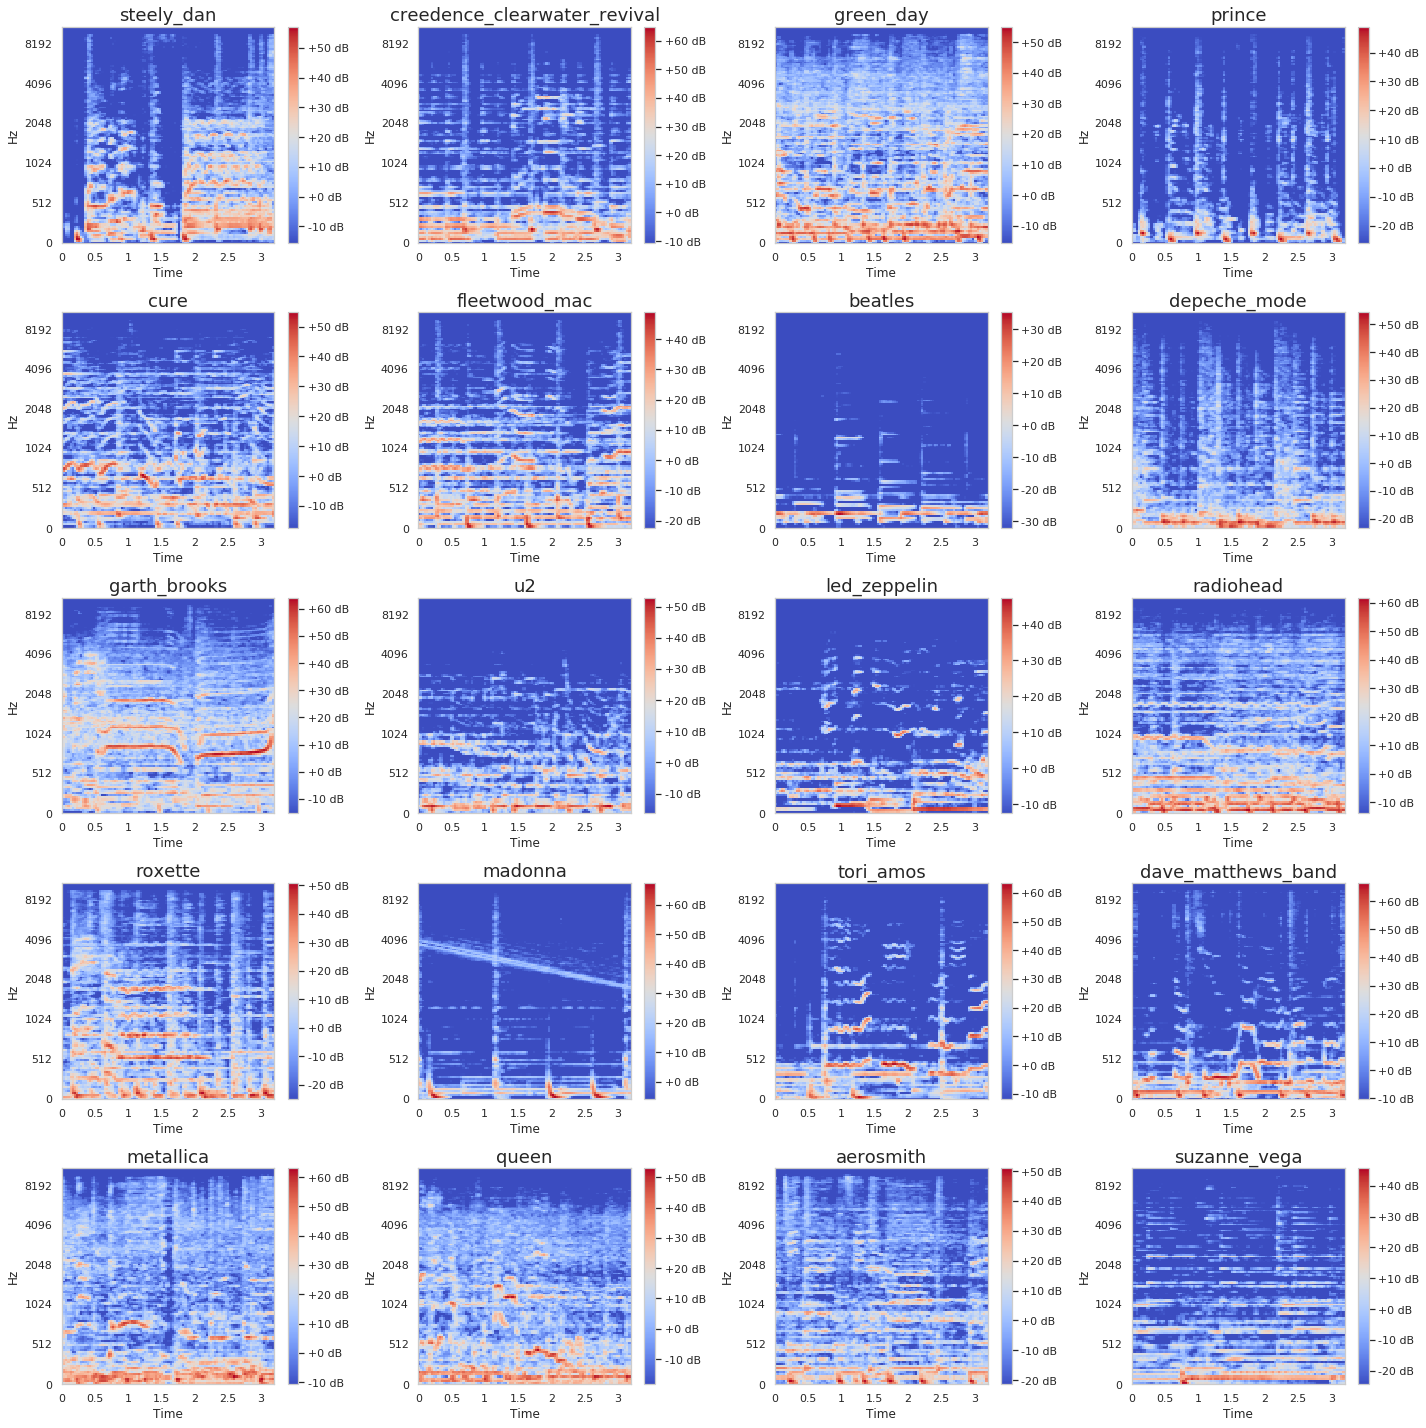

In [56]:
plot_mel(
        song_split_data["test"],
        data_holder,
        SAMPLING_RATE,
        experiment_name="model:song_level:frame_dataset:artist20")

### Эксперименты

## Song-split model, frame-level features

In [ ]:
# YOU CAN USE FUNCTION FOR LAUNCH ONE EXPERIMENT AND GET STATS FOR IT
# OR USE FUNCTION FOR LAUNCH SEVERAL EXPERIMENTS (IF LEARN MORE THAN ONE MODEL) AND GET MEAN AND BEST SCORES ONLY

##### Измени имя эксперимента в каждой клетке на твое имя эксперимента


100%|██████████| 949/949 [00:20<00:00, 45.59it/s]

                              precision    recall  f1-score   support

          dave_matthews_band       0.73      0.85      0.78       778
                   tori_amos       0.67      0.79      0.72       875
creedence_clearwater_revival       0.94      0.92      0.93       775
                     madonna       0.46      0.41      0.43       865
                garth_brooks       0.87      0.82      0.84       660
                depeche_mode       0.73      0.80      0.76       677
                   metallica       0.89      0.95      0.92      1141
                   aerosmith       0.67      0.76      0.71       613
                          u2       0.47      0.30      0.37       648
                   green_day       0.83      0.80      0.81       654
                       queen       0.68      0.45      0.54       755
                led_zeppelin       0.65      0.75      0.70       819
                  steely_dan       0.68      0.75      0.71       463
                   

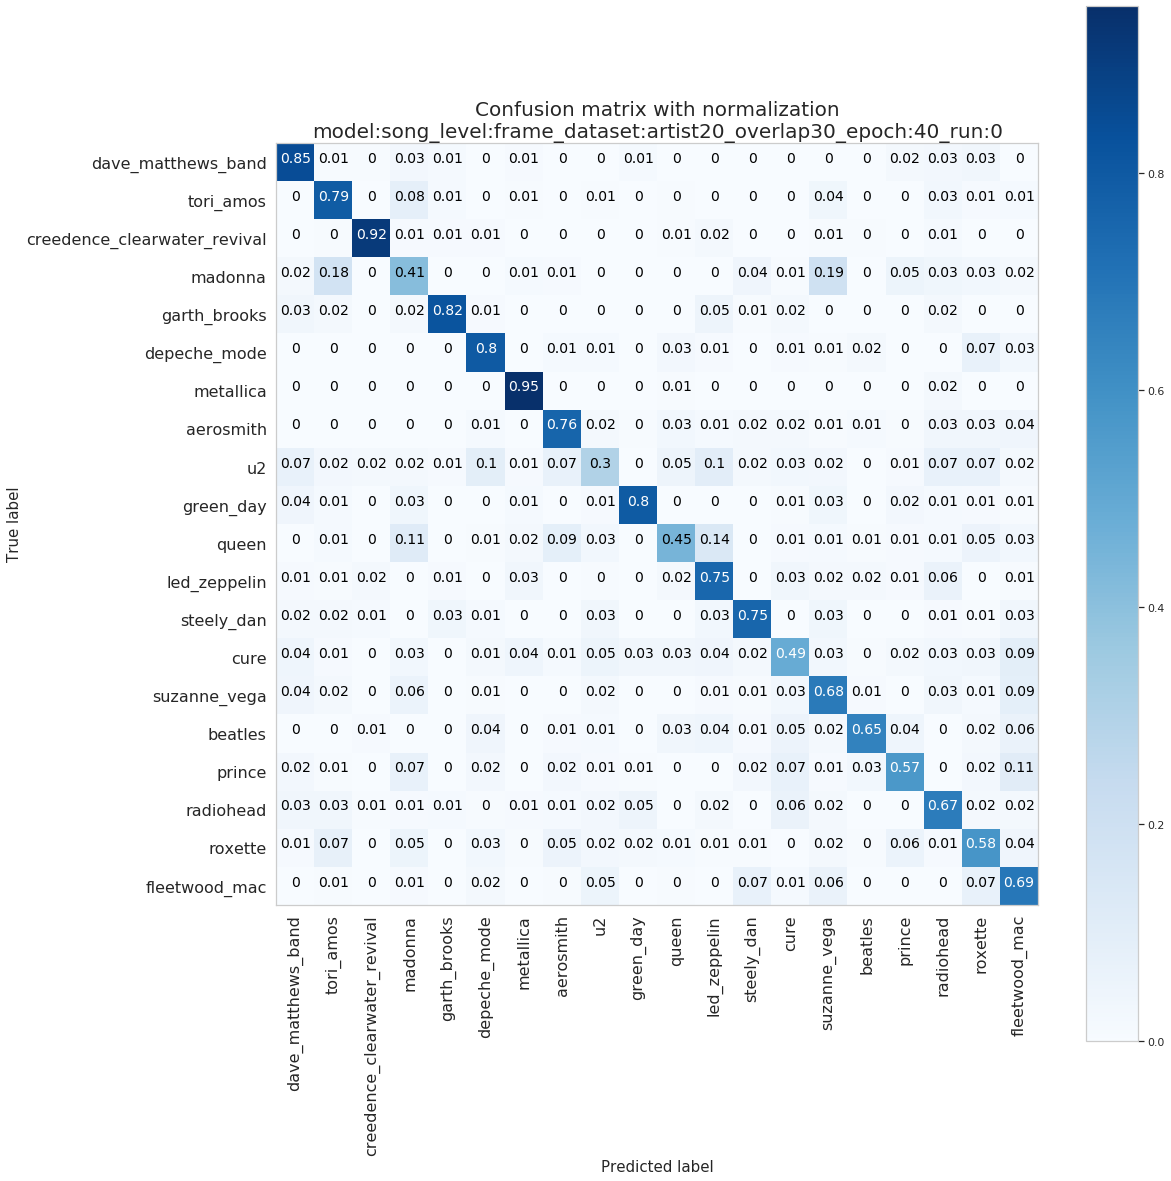

TESTED 1 MODELS
MEAN F1: 0.68
BEST F1: 0.68
MEAN ACCURACY: 0.69
BEST ACCURACY: 0.69


In [22]:
#EXAMPLE:
# report, (f1, accuracy), cm = make_experiment(
#                                         model_song, song_split_data["test"],
#                                         data_holder, feature_level="frame",
#                                         experiment_name="model:song_level:frame_dataset:artist20",
#                                         verbose=True)
# print(f"F1 SCORE: {f1}")
# print(f"ACCURACY: {accuracy}")

#EXAMPLE:

mean_f1, mean_accuracy, best_f1, best_accuracy = make_several_experiments(
                                           models_song2, song_split_data["test"],
                                           data_holder, feature_level="frame",
                                           experiment_name="model:song_level:frame_dataset:artist20_overlap30_epoch:40",
                                           verbose=True)
print(f"TESTED {len(models_song2)} MODELS")
print(f"MEAN F1: {mean_f1}")
print(f"BEST F1: {best_f1}")
print(f"MEAN ACCURACY: {mean_accuracy}")
print(f"BEST ACCURACY: {best_accuracy}")

##### Измени имя эксперимента в каждой клетке на твое имя эксперимента


100%|██████████| 475/475 [00:21<00:00, 23.70it/s]

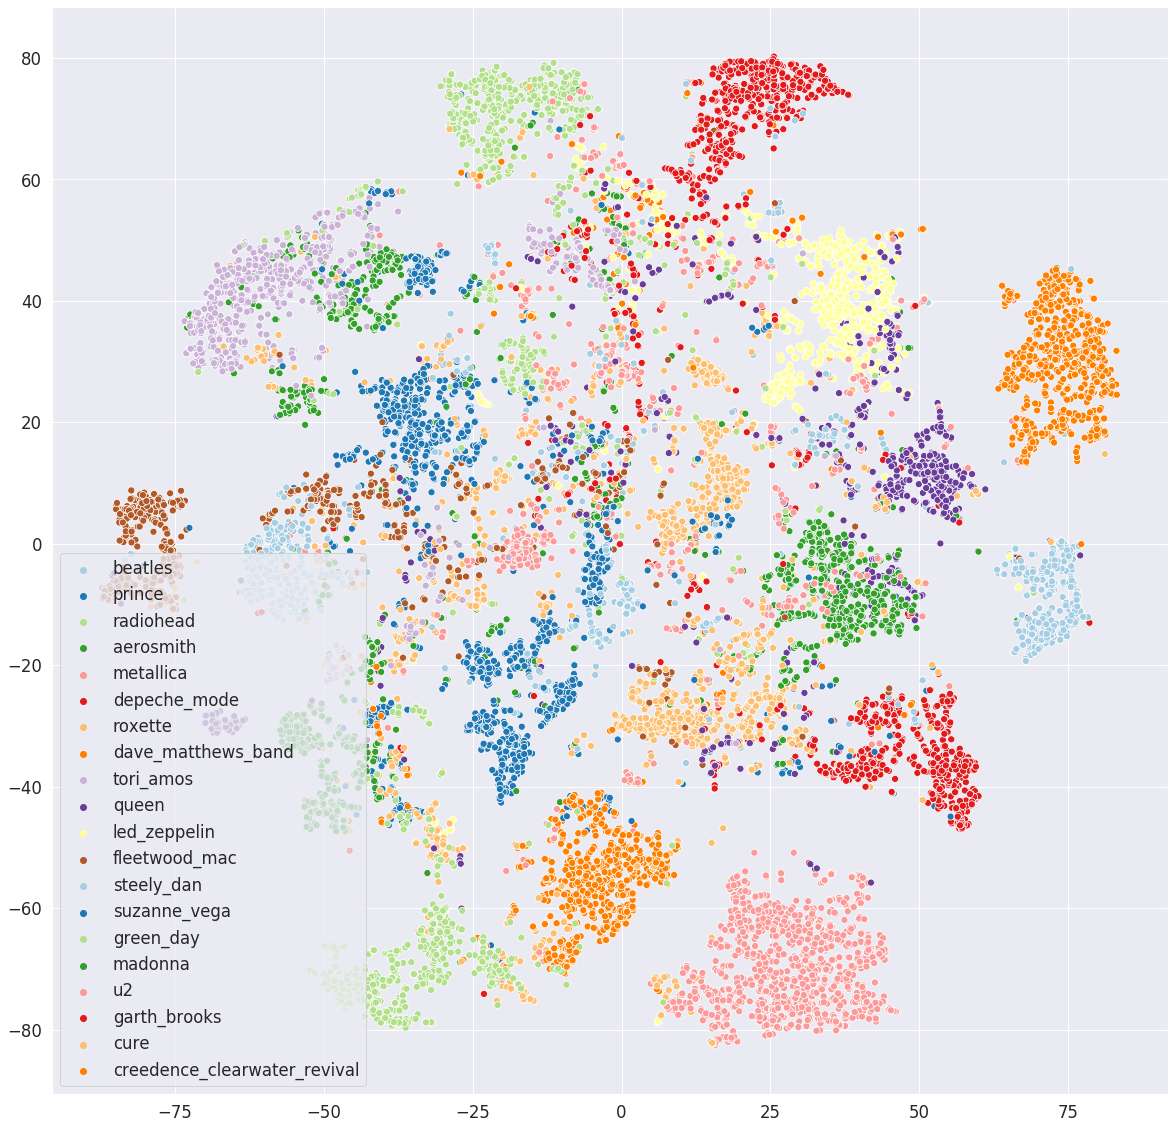

In [23]:
plot_tsne(
        models_song2[-1], song_split_data["test"],
        data_holder, experiment_name="model:song_level:frame_dataset:artist20_overlap30_epoch:40")

## Song-split model, song-level features

##### Измени имя эксперимента в каждой клетке на твое имя эксперимента


100%|██████████| 949/949 [00:20<00:00, 45.72it/s]

                              precision    recall  f1-score   support

          dave_matthews_band       0.88      1.00      0.93         7
                   tori_amos       0.78      0.88      0.82         8
creedence_clearwater_revival       1.00      1.00      1.00         6
                     madonna       0.43      0.43      0.43         7
                garth_brooks       1.00      1.00      1.00         7
                depeche_mode       0.88      1.00      0.93         7
                   metallica       0.88      1.00      0.93         7
                   aerosmith       0.71      1.00      0.83         5
                          u2       1.00      0.33      0.50         6
                   green_day       1.00      1.00      1.00         9
                       queen       1.00      0.50      0.67         8
                led_zeppelin       0.62      1.00      0.77         5
                  steely_dan       0.83      1.00      0.91         5
                   

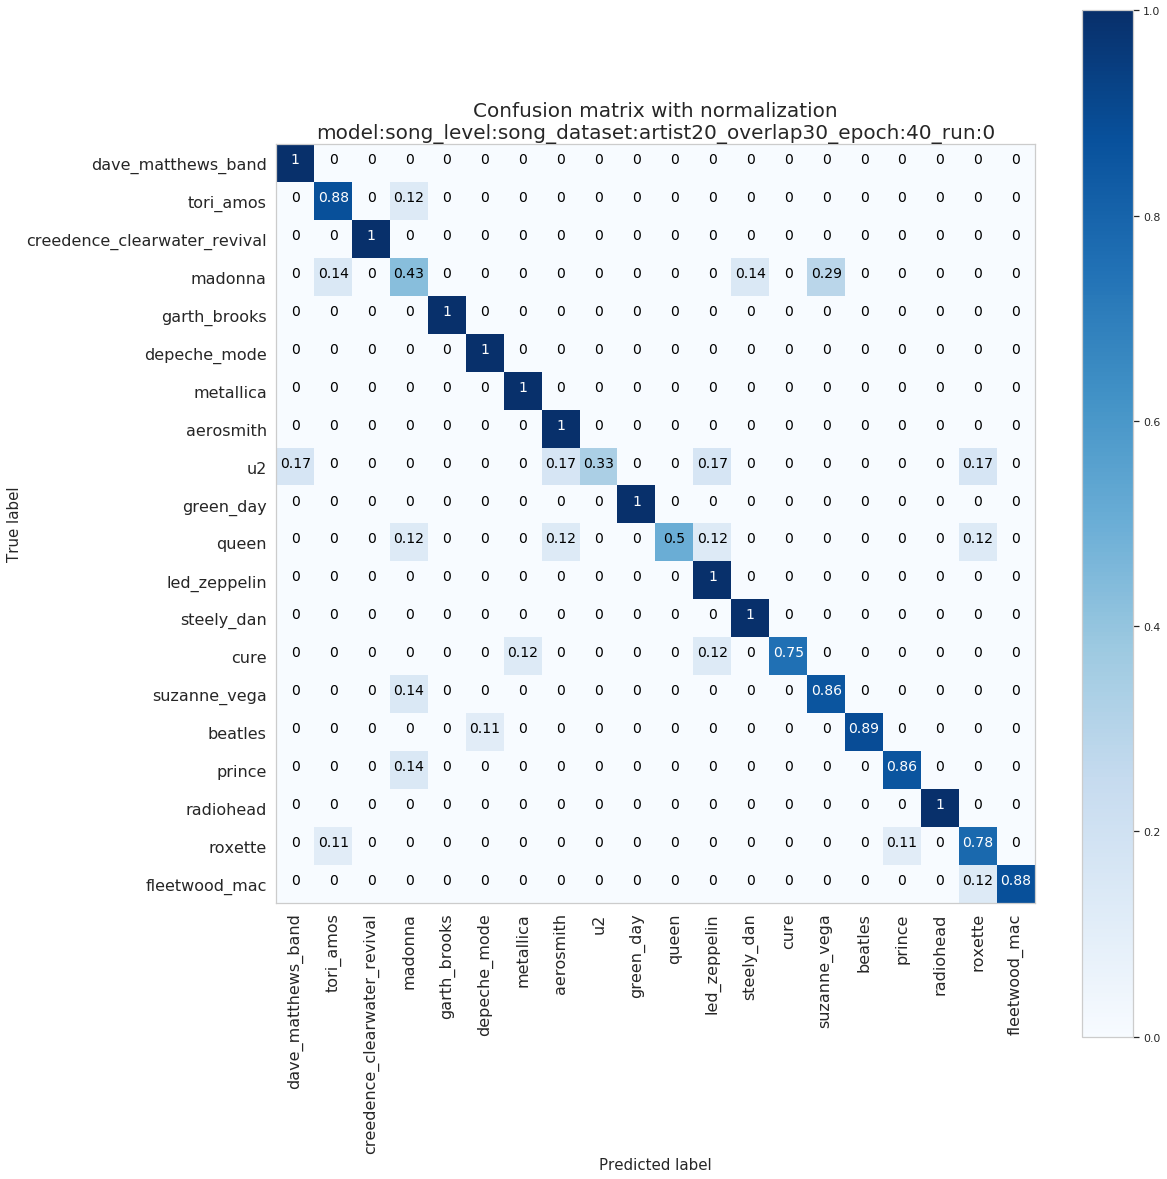

TESTED 1 MODELS
MEAN F1: 0.85
BEST F1: 0.85
MEAN ACCURACY: 0.85
BEST ACCURACY: 0.85


In [24]:
# report, (f1, accuracy), cm = make_experiment(
#                                         model_song, song_split_data["test"],
#                                         data_holder, feature_level="song",
#                                         experiment_name="model:song_level:song_dataset:artist20",
#                                         verbose=True)
# print(f"F1 SCORE: {f1}")
# print(f"ACCURACY: {accuracy}")

mean_f1, mean_accuracy, best_f1, best_accuracy = make_several_experiments(
                                           models_song2, song_split_data["test"],
                                           data_holder, feature_level="song",
                                           experiment_name="model:song_level:song_dataset:artist20_overlap30_epoch:40",
                                           verbose=True)
print(f"TESTED {len(models_song2)} MODELS")
print(f"MEAN F1: {mean_f1}")
print(f"BEST F1: {best_f1}")
print(f"MEAN ACCURACY: {mean_accuracy}")
print(f"BEST ACCURACY: {best_accuracy}")

## Album-split model, frame-level features

##### Измени имя эксперимента в каждой клетке на твое имя эксперимента



  0%|          | 0/1592 [00:00<?, ?it/s]

  0%|          | 4/1592 [00:00<00:53, 29.86it/s]

  1%|          | 8/1592 [00:00<00:50, 31.32it/s]

  1%|          | 12/1592 [00:00<00:49, 31.99it/s]

  1%|          | 16/1592 [00:00<00:47, 32.99it/s]

  1%|▏         | 21/1592 [00:00<00:44, 35.29it/s]

  2%|▏         | 25/1592 [00:00<00:43, 36.36it/s]

  2%|▏         | 30/1592 [00:00<00:41, 37.60it/s]

  2%|▏         | 35/1592 [00:00<00:38, 39.95it/s]

  3%|▎         | 40/1592 [00:01<00:37, 41.80it/s]

  3%|▎         | 45/1592 [00:01<00:35, 43.20it/s]

  3%|▎         | 50/1592 [00:01<00:34, 44.27it/s]

  3%|▎         | 55/1592 [00:01<00:34, 44.98it/s]

  4%|▍         | 60/1592 [00:01<00:33, 45.48it/s]

  4%|▍         | 65/1592 [00:01<00:33, 45.86it/s]

  4%|▍         | 70/1592 [00:01<00:32, 46.13it/s]

  5%|▍         | 75/1592 [00:01<00:32, 46.33it/s]

  5%|▌         | 80/1592 [00:01<00:32, 46.45it/s]

  5%|▌         | 85/1592 [00:01<00:32, 46.54it/s]

  6%|▌         | 90/1592 [00:02<00:32, 4

 88%|████████▊ | 1395/1592 [00:30<00:04, 46.65it/s]

 88%|████████▊ | 1400/1592 [00:30<00:04, 46.69it/s]

 88%|████████▊ | 1405/1592 [00:30<00:04, 46.70it/s]

 89%|████████▊ | 1410/1592 [00:30<00:03, 46.71it/s]

 89%|████████▉ | 1415/1592 [00:30<00:03, 46.48it/s]

 89%|████████▉ | 1420/1592 [00:30<00:03, 46.53it/s]

 90%|████████▉ | 1425/1592 [00:30<00:03, 46.56it/s]

 90%|████████▉ | 1430/1592 [00:30<00:03, 46.55it/s]

 90%|█████████ | 1435/1592 [00:30<00:03, 46.60it/s]

 90%|█████████ | 1440/1592 [00:31<00:03, 46.64it/s]

 91%|█████████ | 1445/1592 [00:31<00:03, 46.68it/s]

 91%|█████████ | 1450/1592 [00:31<00:03, 46.68it/s]

 91%|█████████▏| 1455/1592 [00:31<00:02, 46.66it/s]

 92%|█████████▏| 1460/1592 [00:31<00:02, 46.66it/s]

 92%|█████████▏| 1465/1592 [00:31<00:02, 46.67it/s]

 92%|█████████▏| 1470/1592 [00:31<00:02, 46.67it/s]

 93%|█████████▎| 1475/1592 [00:31<00:02, 45.77it/s]

 93%|█████████▎| 1480/1592 [00:31<00:02, 46.06it/s]

 93%|█████████▎| 1485/1592 [00:32<00:02, 46.20

                              precision    recall  f1-score   support

          dave_matthews_band       0.44      0.75      0.56      1455
                   tori_amos       0.30      0.43      0.36      1441
creedence_clearwater_revival       0.90      0.77      0.83      1140
                     madonna       0.02      0.01      0.01      1361
                garth_brooks       0.67      0.59      0.63      1081
                depeche_mode       0.33      0.42      0.37      1128
                   metallica       0.94      0.88      0.91      2102
                   aerosmith       0.39      0.52      0.44       989
                          u2       0.13      0.17      0.15      1091
                   green_day       0.00      0.00      0.00      1116
                       queen       0.24      0.18      0.21      1095
                led_zeppelin       0.47      0.54      0.50      1191
                  steely_dan       0.53      0.56      0.54       945
                   

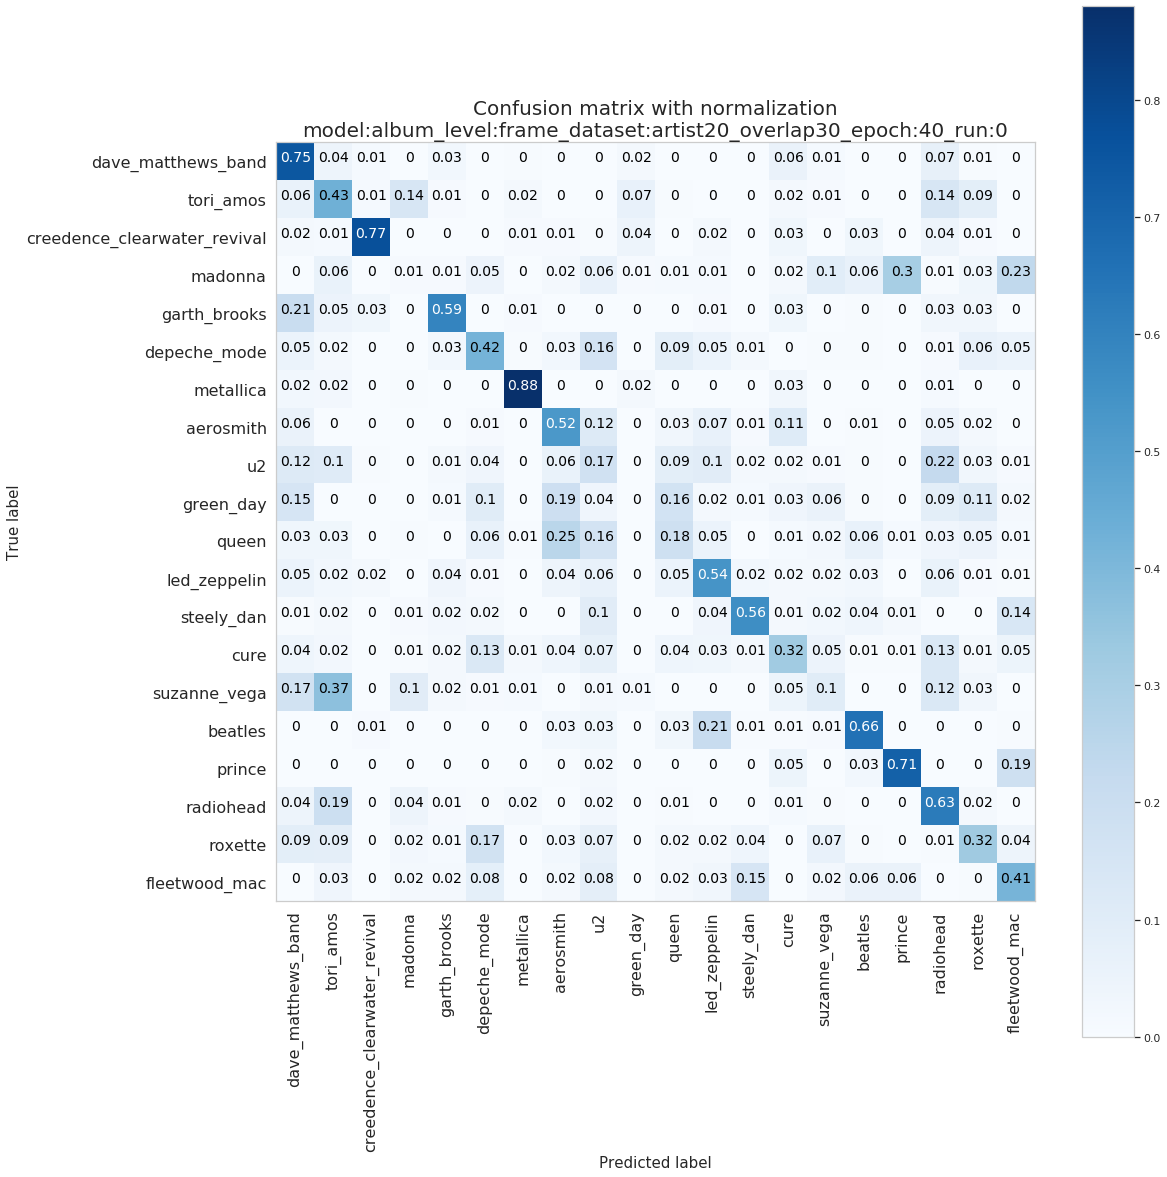

TESTED 1 MODELS
MEAN F1: 0.44
BEST F1: 0.44
MEAN ACCURACY: 0.46
BEST ACCURACY: 0.46


In [28]:
# report, (f1, accuracy), cm = make_experiment(
#                                         model_album, song_split_data["test"],
#                                         data_holder, feature_level="frame",
#                                         experiment_name="model:album_level:frame_dataset:artist20",
#                                         verbose=True)
# print(f"F1 SCORE: {f1}")
# print(f"ACCURACY: {accuracy}")

mean_f1, mean_accuracy, best_f1, best_accuracy = make_several_experiments(
                                           models_album2, album_split_data["test"],
                                           data_holder, feature_level="frame",
                                           experiment_name="model:album_level:frame_dataset:artist20_overlap30_epoch:40",
                                           verbose=True)
print(f"TESTED {len(models_album2)} MODELS")
print(f"MEAN F1: {mean_f1}")
print(f"BEST F1: {best_f1}")
print(f"MEAN ACCURACY: {mean_accuracy}")
print(f"BEST ACCURACY: {best_accuracy}")

##### Измени имя эксперимента в каждой клетке на твое имя эксперимента



  0%|          | 0/796 [00:00<?, ?it/s]

  0%|          | 2/796 [00:00<00:39, 19.90it/s]

  1%|          | 5/796 [00:00<00:38, 20.51it/s]

  1%|          | 7/796 [00:00<00:38, 20.32it/s]

  1%|▏         | 10/796 [00:00<00:37, 21.22it/s]

  2%|▏         | 13/796 [00:00<00:35, 21.92it/s]

  2%|▏         | 16/796 [00:00<00:34, 22.41it/s]

  2%|▏         | 19/796 [00:00<00:37, 20.79it/s]

  3%|▎         | 22/796 [00:01<00:37, 20.90it/s]

  3%|▎         | 25/796 [00:01<00:36, 21.04it/s]

  4%|▎         | 28/796 [00:01<00:36, 20.94it/s]

  4%|▍         | 31/796 [00:01<00:35, 21.37it/s]

  4%|▍         | 34/796 [00:01<00:36, 20.95it/s]

  5%|▍         | 37/796 [00:01<00:37, 20.17it/s]

  5%|▌         | 40/796 [00:01<00:36, 20.71it/s]

  5%|▌         | 43/796 [00:02<00:34, 21.52it/s]

  6%|▌         | 46/796 [00:02<00:33, 22.15it/s]

  6%|▌         | 49/796 [00:02<00:33, 22.62it/s]

  7%|▋         | 52/796 [00:02<00:34, 21.52it/s]

  7%|▋         | 55/796 [00:02<00:33, 22.12it/s]

  7%|▋    

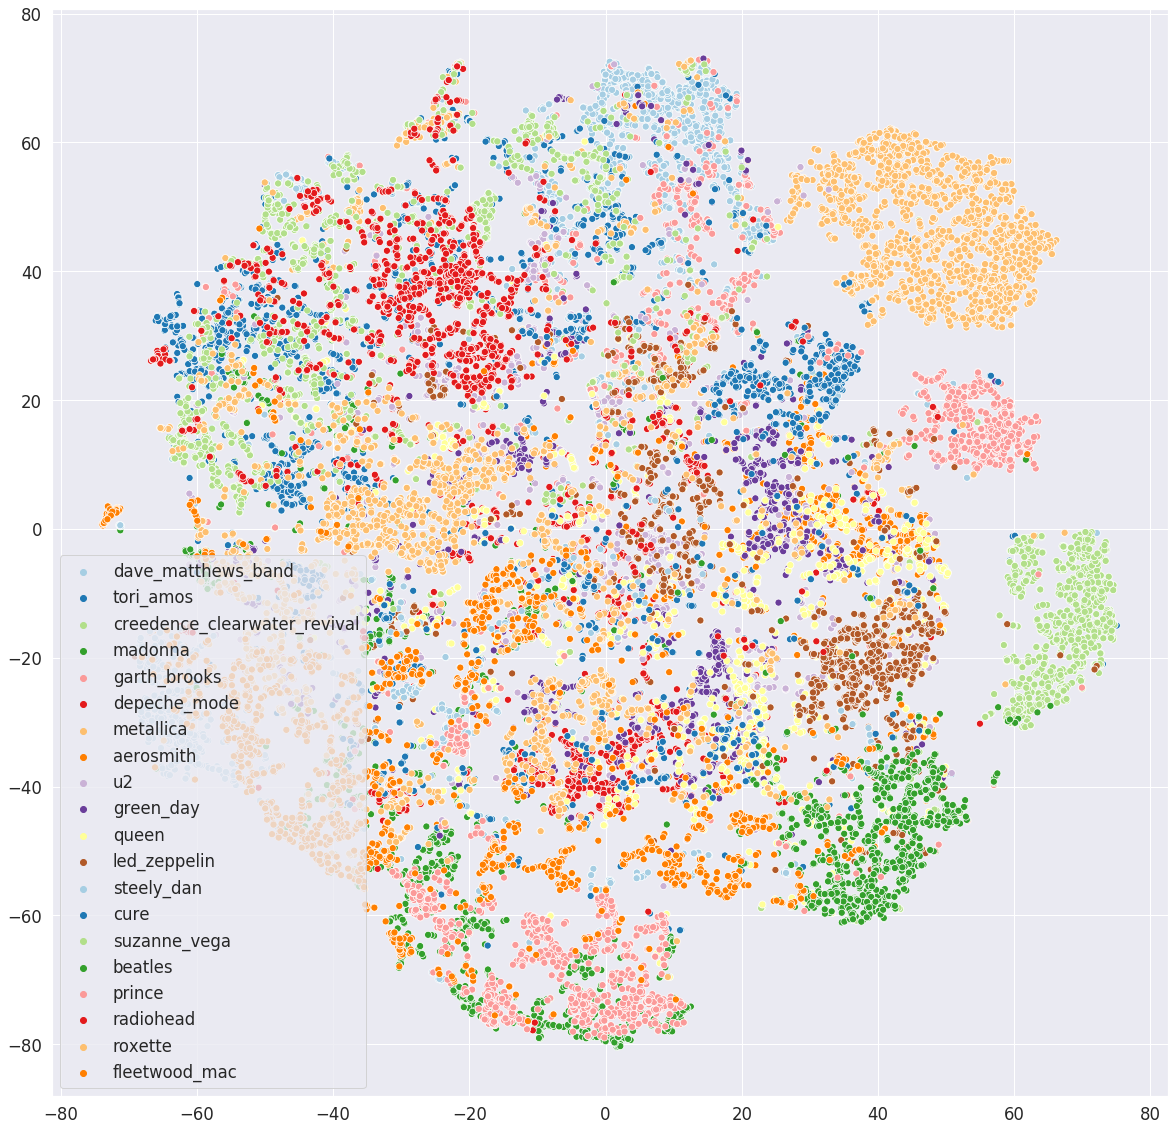

In [30]:
plot_tsne(
        models_album2[-1], album_split_data["test"],
        data_holder, experiment_name="model:album_level:frame_dataset:artist20_overlap30_epoch:40")

## Album-split model, song-level features

##### Измени имя эксперимента в каждой клетке на твое имя эксперимента



  0%|          | 0/1592 [00:00<?, ?it/s]

  0%|          | 4/1592 [00:00<00:49, 32.39it/s]

  0%|          | 7/1592 [00:00<00:50, 31.13it/s]

  1%|          | 11/1592 [00:00<00:48, 32.38it/s]

  1%|          | 15/1592 [00:00<00:48, 32.79it/s]

  1%|          | 19/1592 [00:00<00:46, 33.66it/s]

  2%|▏         | 24/1592 [00:00<00:43, 35.97it/s]

  2%|▏         | 28/1592 [00:00<00:42, 37.00it/s]

  2%|▏         | 32/1592 [00:00<00:51, 30.37it/s]

  2%|▏         | 36/1592 [00:01<00:47, 32.70it/s]

  3%|▎         | 41/1592 [00:01<00:43, 35.96it/s]

  3%|▎         | 46/1592 [00:01<00:39, 38.67it/s]

  3%|▎         | 51/1592 [00:01<00:37, 40.80it/s]

  4%|▎         | 56/1592 [00:01<00:36, 42.40it/s]

  4%|▍         | 61/1592 [00:01<00:35, 43.65it/s]

  4%|▍         | 66/1592 [00:01<00:34, 44.56it/s]

  4%|▍         | 71/1592 [00:01<00:33, 45.21it/s]

  5%|▍         | 76/1592 [00:01<00:33, 45.64it/s]

  5%|▌         | 81/1592 [00:02<00:32, 45.97it/s]

  5%|▌         | 86/1592 [00:02<00:32, 4

 87%|████████▋ | 1391/1592 [00:30<00:04, 46.59it/s]

 88%|████████▊ | 1396/1592 [00:30<00:04, 46.56it/s]

 88%|████████▊ | 1401/1592 [00:30<00:04, 46.53it/s]

 88%|████████▊ | 1406/1592 [00:30<00:03, 46.54it/s]

 89%|████████▊ | 1411/1592 [00:30<00:03, 46.56it/s]

 89%|████████▉ | 1416/1592 [00:30<00:03, 46.58it/s]

 89%|████████▉ | 1421/1592 [00:30<00:03, 46.57it/s]

 90%|████████▉ | 1426/1592 [00:30<00:03, 46.57it/s]

 90%|████████▉ | 1431/1592 [00:31<00:03, 46.56it/s]

 90%|█████████ | 1436/1592 [00:31<00:03, 46.57it/s]

 91%|█████████ | 1441/1592 [00:31<00:03, 46.33it/s]

 91%|█████████ | 1446/1592 [00:31<00:03, 46.39it/s]

 91%|█████████ | 1451/1592 [00:31<00:03, 46.44it/s]

 91%|█████████▏| 1456/1592 [00:31<00:02, 46.47it/s]

 92%|█████████▏| 1461/1592 [00:31<00:02, 46.46it/s]

 92%|█████████▏| 1466/1592 [00:31<00:02, 46.53it/s]

 92%|█████████▏| 1471/1592 [00:31<00:02, 46.52it/s]

 93%|█████████▎| 1476/1592 [00:31<00:02, 46.45it/s]

 93%|█████████▎| 1481/1592 [00:32<00:02, 46.46

                              precision    recall  f1-score   support

          dave_matthews_band       0.40      0.91      0.56        11
                   tori_amos       0.40      0.67      0.50        12
creedence_clearwater_revival       1.00      0.91      0.95        11
                     madonna       0.00      0.00      0.00        11
                garth_brooks       0.82      0.82      0.82        11
                depeche_mode       0.38      0.50      0.43        10
                   metallica       1.00      1.00      1.00        14
                   aerosmith       0.42      0.89      0.57         9
                          u2       0.29      0.18      0.22        11
                   green_day       0.00      0.00      0.00        16
                       queen       0.27      0.21      0.24        14
                led_zeppelin       0.62      0.89      0.73         9
                  steely_dan       0.69      0.90      0.78        10
                   

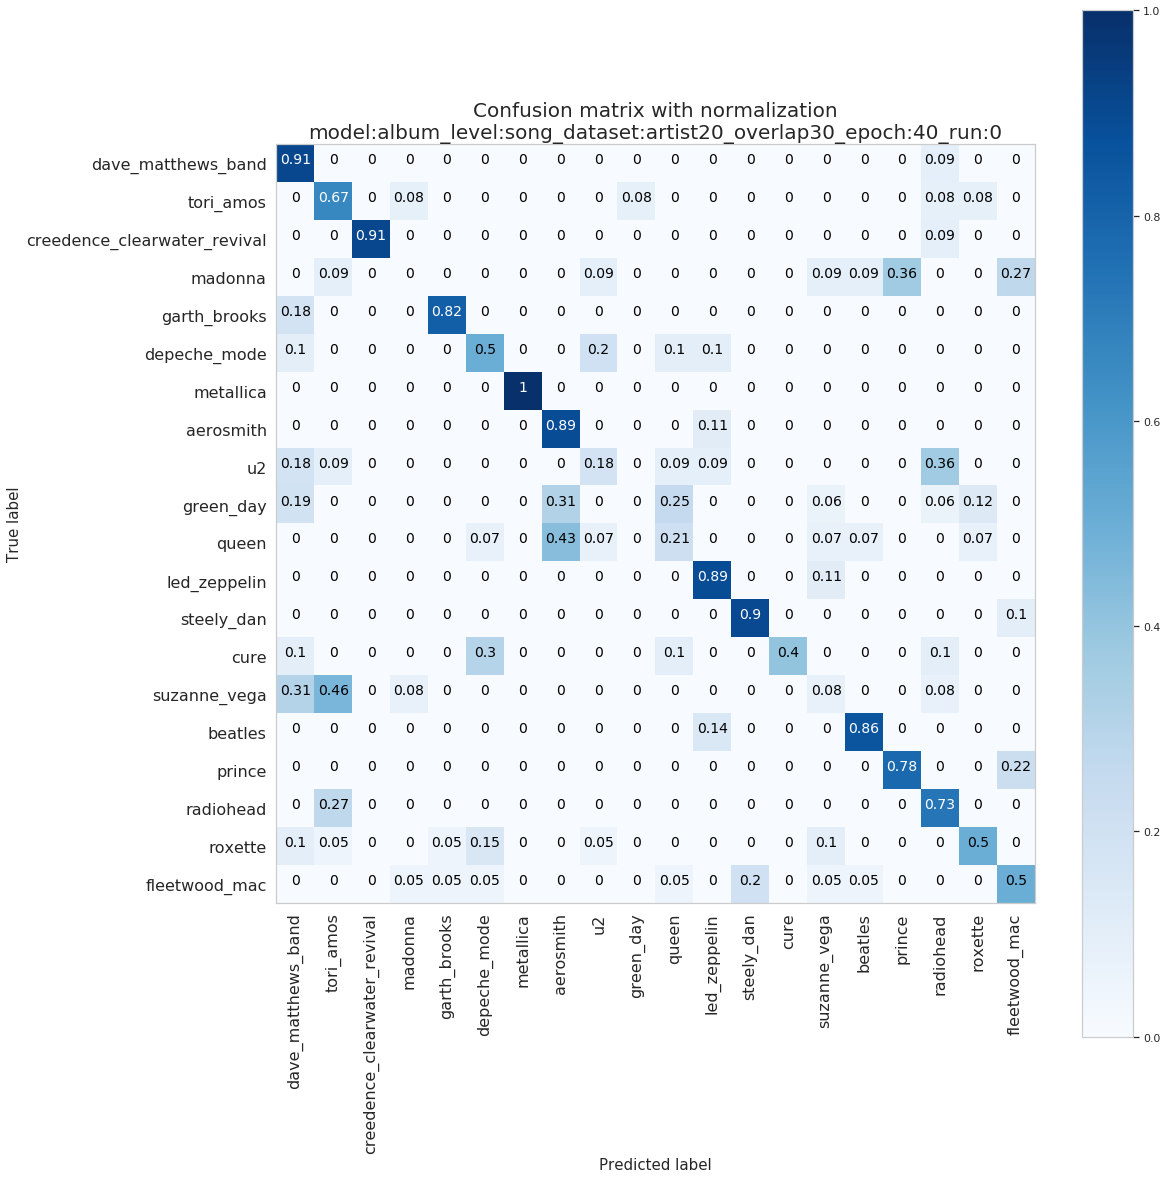

TESTED 1 MODELS
MEAN F1: 0.52
BEST F1: 0.52
MEAN ACCURACY: 0.56
BEST ACCURACY: 0.56


In [31]:
# report, (f1, accuracy), cm = make_experiment(
#                                         model_album, song_split_data["test"],
#                                         data_holder, feature_level="song",
#                                         experiment_name="model:album_level:song_dataset:artist20",
#                                         verbose=True)
# print(f"F1 SCORE: {f1}")
# print(f"ACCURACY: {accuracy}")

mean_f1, mean_accuracy, best_f1, best_accuracy = make_several_experiments(
                                           models_album2, album_split_data["test"],
                                           data_holder, feature_level="song",
                                           experiment_name="model:album_level:song_dataset:artist20_overlap30_epoch:40",
                                           verbose=True)
print(f"TESTED {len(models_album2)} MODELS")
print(f"MEAN F1: {mean_f1}")
print(f"BEST F1: {best_f1}")
print(f"MEAN ACCURACY: {mean_accuracy}")
print(f"BEST ACCURACY: {best_accuracy}")